# Example using an AmeriFlux site and the ``flux-data-qaqc`` Python module

This flux tower site is in Ohio near Lake Erie in a crop (wheat and soy) setting near a marsh. For more information on the site visit AmeriFlux here: [https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview](https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview)

The data file and the [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/) configuration file has been included with this notebook so that the half-hourly data can be easily accessed. 

In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pyproj
import pyproj as proj
from fluxdataqaqc import Data
from rasterio.plot import show
import xarray as xr
import rioxarray
#from rio.crs import CRS

In [2]:

from micromet import volk as ffp


In [3]:
import logging
###############################################################################
# Configure logging
###############################################################################
logger = logging.getLogger(__name__)

logger.setLevel(logging.DEBUG)
# You can send logs to stdout, a file, or elsewhere. Here we just use StreamHandler:
stream_handler = logging.StreamHandler()
# Customize the log format
formatter = logging.Formatter(
    "%(asctime)s [%(levelname)s] %(name)s:%(lineno)d: %(message)s\n"
)
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)



# Read in data using [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/), resample to hourly

Note that some wind variables are not excplicitly required by [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/), i.e. not automatically referenced in the config and objects, to load them here we added the ``load_all_vars`` metadata option and refer to them by their respective names in the climate data file "AMF_US-CRT_BASE_HH_3-5.csv". In this case these variables are Monin-Obukhov length "MO_LENGTH", standard deviation of lateral velocity fluctuations "V_SIGMA", and friction velocity "USTAR".

# Convert station lat/lon to local UTM for georeferencing

This example converts the geographic coordinates to the local UTM zone and produces a raster image in that reprojected coordinate reference system.

In [24]:
from pyproj import Transformer
EPSG = 5070
# load initial flux data
d = Data('./Processing Workflow Notebooks/US-CRT_config.ini')
# adding variable names to Data instance name list for resampling
d.variables['MO_LENGTH'] = 'MO_LENGTH'
d.variables['USTAR'] = 'USTAR'
d.variables['V_SIGMA'] = 'V_SIGMA'
# renaming columns (optional and only affects windspeed and wind direction names)
df = d.df.rename(columns=d.inv_map)
#df = df.copy().loc['2024-07-03 00:00':]
df = df.resample('h').mean()
print(df.head())


# get coords info from Data instance
latitude = d.latitude
longitude = d.longitude
station_coord = (latitude, longitude)
station = d.site_id


# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG}", always_xy=True)

# Perform the transformation
station_x, station_y = transformer.transform(longitude, latitude)

print(f"Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X={station_x}, Y={station_y}")


                           H  LE          G        wd       ws    USTAR  \
date                                                                      
2011-01-01 00:00:00      NaN NaN  27.185665       NaN      NaN      NaN   
2011-01-01 01:00:00      NaN NaN  34.094585       NaN      NaN      NaN   
2011-01-01 02:00:00 -27.8487 NaN  29.311130  254.7010  3.11869  0.27374   
2011-01-01 03:00:00 -29.3102 NaN  31.965615  232.3775  4.27658  0.27932   
2011-01-01 04:00:00      NaN NaN  25.104715       NaN      NaN      NaN   

                     MO_LENGTH   V_SIGMA    t_avg         rh        Rn  sw_in  \
date                                                                            
2011-01-01 00:00:00        NaN       NaN      NaN  89.986134  4.719121    0.0   
2011-01-01 01:00:00        NaN       NaN      NaN  81.941805  3.683791    0.0   
2011-01-01 02:00:00  69.337979  1.375590  11.8705  80.890344  4.630846    0.0   
2011-01-01 03:00:00  76.689723  0.979255  11.7439  91.686902 -0.37991

In [25]:
print(d.latitude, d.longitude)

41.6285 -83.3471


# Estimate remaining parameters and create daily footprint rasters with hourly footprints as bands

A few assumptions, the canopy height of 0.2 meters is constant, this site according to the owners is winter wheat and soybean rotation. Displacement height was not given but estimated for cropland as $d = 10^{0.979 \log_{10} hc - 0.154}$. Also, planetary boundary layer height was assigned as 2 km. Roughness length was also estimated as $0.123 h_c$. The footprints in this example are only calculated for hours between 7 AM and 8 PM, this alongwith footprint array domain, resolution, and other options are all easily adjustable using the arguments to the Kljun et al., (2015) footprint function.

# Produce a flux footprint for a single day

In [23]:
d

np.float64(1.1792597999461316)

In [26]:
#Other model parameters
h_c = 1.7 #Height of canopy [m]
# Estimated displacement height [m]
d = 10**(0.979* np.log10(h_c) - 0.154)

zm_s = 4.5 #Measurement height [m] from AMF metadata
h_s = 2000. #Height of atmos. boundary layer [m] - assumed
dx = 3. #Model resolution [m]
origin_d = 300. #Model bounds distance from origin [m]
# from 7 AM to 8 PM only, modify if needed
start_hr = 7
end_hr = 20
hours = np.arange(start_hr,end_hr+1)
df['zm'] = zm_s - d
df['h_c'] = h_c
df['z0'] = h_c*.123
date = pd.to_datetime('2011-01-11')
temp_line = df[(df.index >= pd.to_datetime('2011-01-01 7:00')) & (df.index <= pd.to_datetime('2011-01-01 20:00'))]
temp_ffp = ffp.ffp_climatology_new(df=temp_line,
                                   domain=[-origin_d,origin_d,-origin_d,origin_d],
                               dx=dx,
                               dy=dx,
                        crop=0,
                                   logger=logger,
                                   smooth_data=False,
                                   time = temp_line.index.hour,
                                   fig=0,)
temp_ffp.run()


ds = temp_ffp.f_2d
x_2d = temp_ffp.f_2d.x + station_x
y_2d = temp_ffp.f_2d.y + station_y
#f_2d = ds.values*dx**2

ds_albers = ds.assign_coords(x=x_2d, y=y_2d).rio.write_crs(5070)
ds_albers_day = temp_ffp.fclim_2d.assign_coords(x=x_2d, y=y_2d).rio.write_crs(5070)
#ds_utm =  ds_albers.rio.reproject(ds_albers.rio.estimate_utm_crs())

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis12\Lib\site-packages\xarray\core\computation.py:831: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


In [61]:
import matplotlib.pyplot as plt
import numpy as np

class ContourUtils:
    @staticmethod
    def get_contour_levels(f_2d, vmin=None, vmax=None, num_levels=10):
        """
        Determine contour levels for a 2D function.

        Parameters:
        - f_2d (xarray.DataArray): 2D data array.
        - vmin (float, optional): Minimum value for contours. Defaults to data minimum.
        - vmax (float, optional): Maximum value for contours. Defaults to data maximum.
        - num_levels (int, optional): Number of contour levels. Defaults to 10.

        Returns:
        - levels (list): List of contour levels.
        """
        if vmin is None:
            vmin = f_2d.min().item()
        if vmax is None:
            vmax = f_2d.max().item()

        locator = ticker.MaxNLocator(nbins=num_levels)
        levels = locator.tick_values(vmin, vmax)

        return levels

    def get_time_varying_contour_levels(self, f_3d, vmin=None, vmax=None, num_levels=10):
        """
        Determine contour levels for a 3D xarray.DataArray over time.

        Parameters:
        - f_3d (xarray.DataArray): 3D data array with dimensions (time, x, y).
        - vmin (float, optional): Minimum value for contours. Defaults to global data minimum.
        - vmax (float, optional): Maximum value for contours. Defaults to global data maximum.
        - num_levels (int, optional): Number of contour levels. Defaults to 10.

        Returns:
        - levels_dict (dict): Dictionary with time as keys and contour levels as values.
        """
        if vmin is None:
            vmin = f_3d.min().item()
        if vmax is None:
            vmax = f_3d.max().item()

        levels_dict = {}
        for t in f_3d.time:
            f_2d = f_3d.sel(time=t)
            levels_dict[str(t.values)] = self.get_contour_levels(f_2d, vmin, vmax, num_levels)

        return levels_dict

    def plot_top_9_contour_levels(self, f_data, contour_levels, time_index=None):
        """
        Plot contours cropped to the top 9 categories for 3D xarray.DataArray.

        Parameters:
        - f_data (xarray.DataArray): 3D data array with dimensions (time, x, y).
        - contour_levels (dict): Dictionary with time as keys and contour levels as values.
        - time_index (int, optional): Index of the time slice to plot.
        """
        def plot(f_2d, levels, title):
            levels_sorted = np.sort(levels)
            cropped_levels = levels_sorted[-9:] if len(levels_sorted) >= 9 else levels_sorted

            if len(cropped_levels) == 0:
                print(f"No valid levels to plot for {title}.")
                return

            mask = (f_2d >= cropped_levels[0]) & (f_2d <= cropped_levels[-1])
            f_2d_cropped = f_2d.where(mask, drop=True)

            x_values = f_2d_cropped.x.values
            y_values = f_2d_cropped.y.values

            plt.figure(figsize=(8, 6))
            contour = plt.contourf(x_values, y_values, f_2d_cropped.values, levels=cropped_levels, cmap="viridis")
            plt.colorbar(contour, label="Value")
            plt.title(title)
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.xlim(x_values.min(), x_values.max())
            plt.ylim(y_values.min(), y_values.max())
            plt.show()

        if time_index is not None:
            f_2d = f_data.isel(time=time_index)
            time_key = str(f_data.time[time_index].values)
            plot(f_2d, contour_levels[time_key], f"Top 9 Categories Contour Plot for Time: {time_key}")
        else:
            for t in f_data.time:
                f_2d = f_data.sel(time=t)
                time_key = str(t.values)
                plot(f_2d, contour_levels[time_key], f"Top 9 Categories Contour Plot for Time: {time_key}")

    def plot_top_9_contour_levels_2d(self, f_2d, contour_levels):
        """
        Plot contours cropped to the top 9 categories for 2D xarray.DataArray.

        Parameters:
        - f_2d (xarray.DataArray): 2D data array with dimensions (x, y).
        - contour_levels (list): List of contour levels.
        """
        levels_sorted = np.sort(contour_levels)
        cropped_levels = levels_sorted[-9:] if len(levels_sorted) >= 9 else levels_sorted

        if len(cropped_levels) == 0:
            print("No valid levels to plot.")
            return

        mask = (f_2d >= cropped_levels[0]) & (f_2d <= cropped_levels[-1])
        f_2d_cropped = f_2d.where(mask, drop=True)

        # Ensure x and y align with data dimensions
        x_values = f_2d_cropped.x.values
        y_values = f_2d_cropped.y.values

        if f_2d_cropped.shape != (len(y_values), len(x_values)):
            print("Adjusting coordinates to match data dimensions.")
            x_values = np.arange(f_2d_cropped.shape[1])
            y_values = np.arange(f_2d_cropped.shape[0])

        plt.figure(figsize=(8, 6))
        contour = plt.contourf(x_values, y_values, f_2d_cropped.values, levels=cropped_levels, cmap="viridis")
        plt.colorbar(contour, label="Value")
        plt.title("Top 9 Categories Contour Plot")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.xlim(x_values.min(), x_values.max())
        plt.ylim(y_values.min(), y_values.max())
        plt.show()


# Example usage
# Assuming `f_3d` is a 3D xarray.DataArray and `contour_levels` is computed using the class above:
# utils = ContourUtils()
# contour_levels = utils.get_time_varying_contour_levels(f_3d)
# utils.plot_top_9_contour_levels(f_3d, contour_levels, time_index=0)
# For 2D data:
# f_2d = f_3d.mean(dim="time")
# levels = utils.get_contour_levels(f_2d)
# utils.plot_top_9_contour_levels_2d(f_2d, levels)


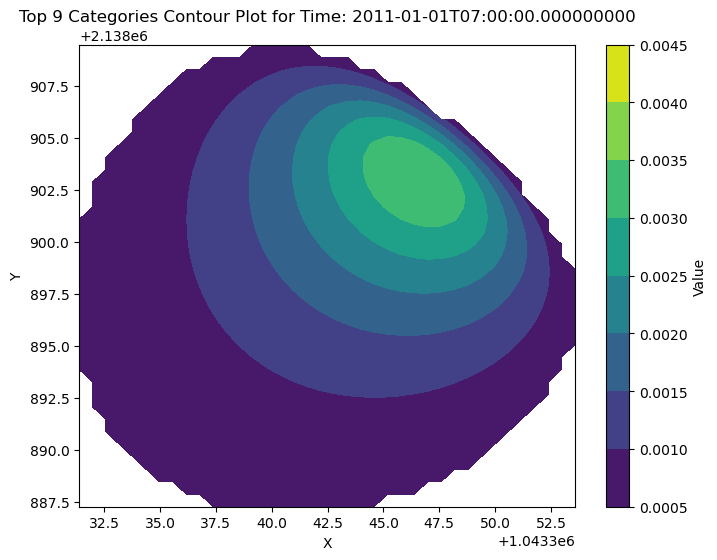

In [62]:



# Example usage
# Assuming `f_3d` is a 3D xarray.DataArray and `contour_levels` is computed using the class above:
f_3d = ds_albers
utils = ContourUtils()
contour_levels = utils.get_time_varying_contour_levels(f_3d)
utils.plot_top_9_contour_levels(f_3d, contour_levels, time_index=0)


Adjusting coordinates to match data dimensions.


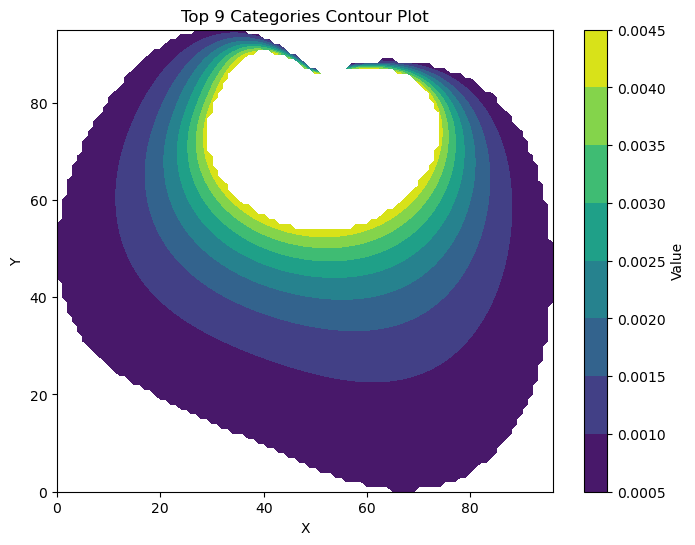

In [63]:
f_2d = ds_albers_day
utils = ContourUtils()
contour_levels = utils.get_contour_levels(f_3d)
utils.plot_top_9_contour_levels_2d(f_2d, contour_levels)


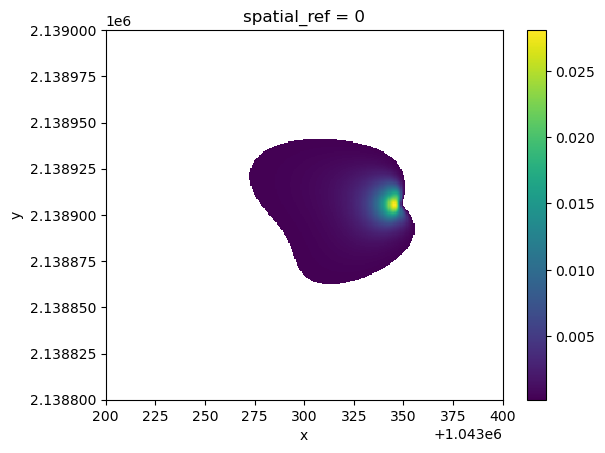

In [60]:
ds_albers_day_filt = xr.where(ds_albers_day>0.0002,ds_albers_day,np.nan)
ds_albers_day_filt.plot(x="x",y="y",xlim=[1043200,1043400],ylim=[2138800,2139000])

In [45]:
contour_levels

array([0.   , 0.003, 0.006, 0.009, 0.012, 0.015, 0.018, 0.021, 0.024,
       0.027, 0.03 ])

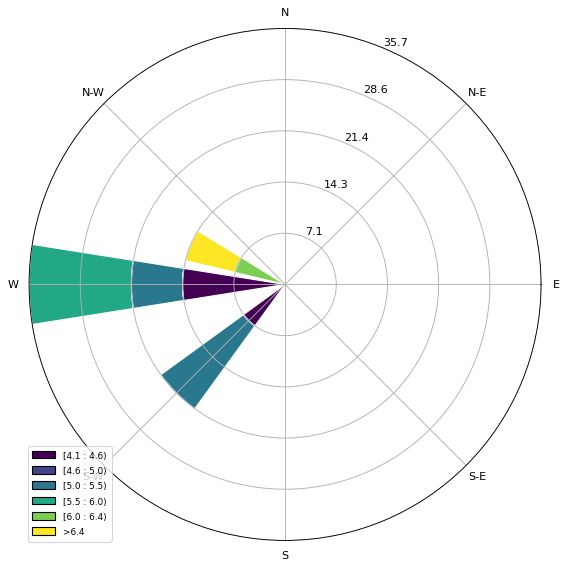

In [13]:
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(temp_line['wd'], temp_line['ws'], normed=True, opening=0.8, edgecolor="white")
ax.set_legend()

# View footprint raster

First plot shows georeferenced (UTM zone 17) footprint (first bad at 7:00 AM) and the plot below shows a different hour, the third plot shows the daily average using matplotlib. Not the second two plots are not georefenced and the axes are in pixel count.

In [20]:
plt.figure(figsize=(14,14))
src = rasterio.open("2024-07-22_US-UTP.tif")
show(src)

RasterioIOError: '2024-07-22_US-UTP.tif' not recognized as being in a supported file format.

<Figure size 1400x1400 with 0 Axes>

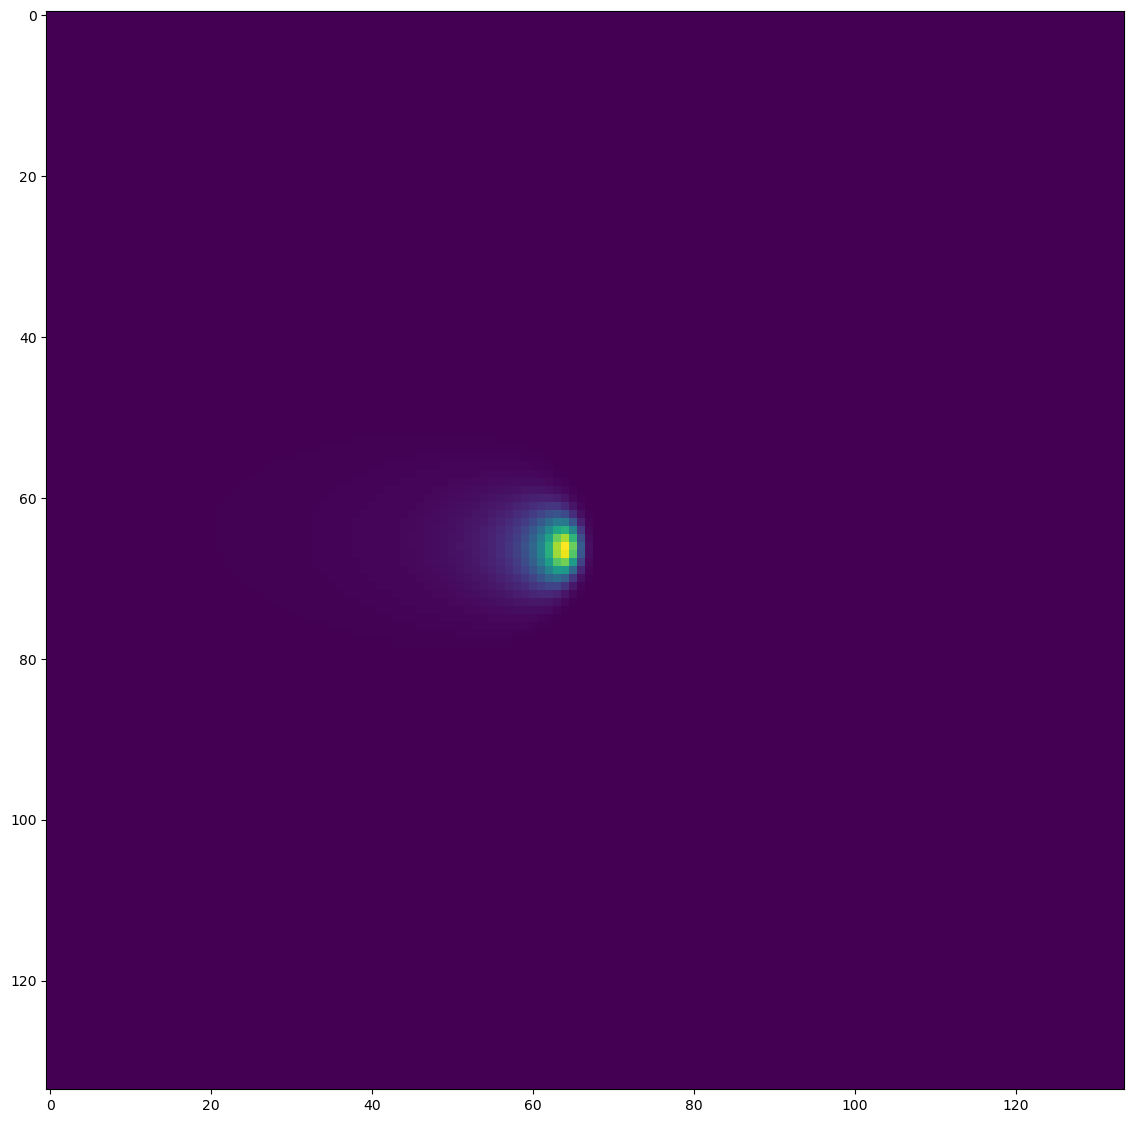

<Axes: >

In [11]:
# view a band for the hour of 10:00 AM (4th band)
plt.figure(figsize=(14,14))
src = rasterio.open("../../footprints/data/2011-01-01_US-CRT.tif")
show(src.read(4))